In [1]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.error_functions import *
from src.visualization import *
from src.evaluation import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
keras.backend.set_floatx('float64')

Using TensorFlow backend.


# Load Data

In [23]:
EPOCHS = 100
BATCH_SIZE = 100
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 20
FEATURES_NUMBER = 2
OUTPUT_SIZE = HORIZON*2
PI_CONFEDENCE=1.1
STD_WEIGHT = 1
LOSS = kl_loss(PI_CONFEDENCE, STD_WEIGHT)
PI_PARAMS = {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}

data_loader = M4DataLoader("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv",
                  LOOKBACK, HORIZON,  validation_ratio=0.05, pi_params=PI_PARAMS)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
validate_x, validate_y = data_loader.get_validation_data()

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE, FEATURES_NUMBER)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE, FEATURES_NUMBER)
validation_data_generator = M4Generator(validate_x, validate_y, BATCH_SIZE, FEATURES_NUMBER)

-1.1232156668806597
-1.3586846548012366
-0.8877466789600827


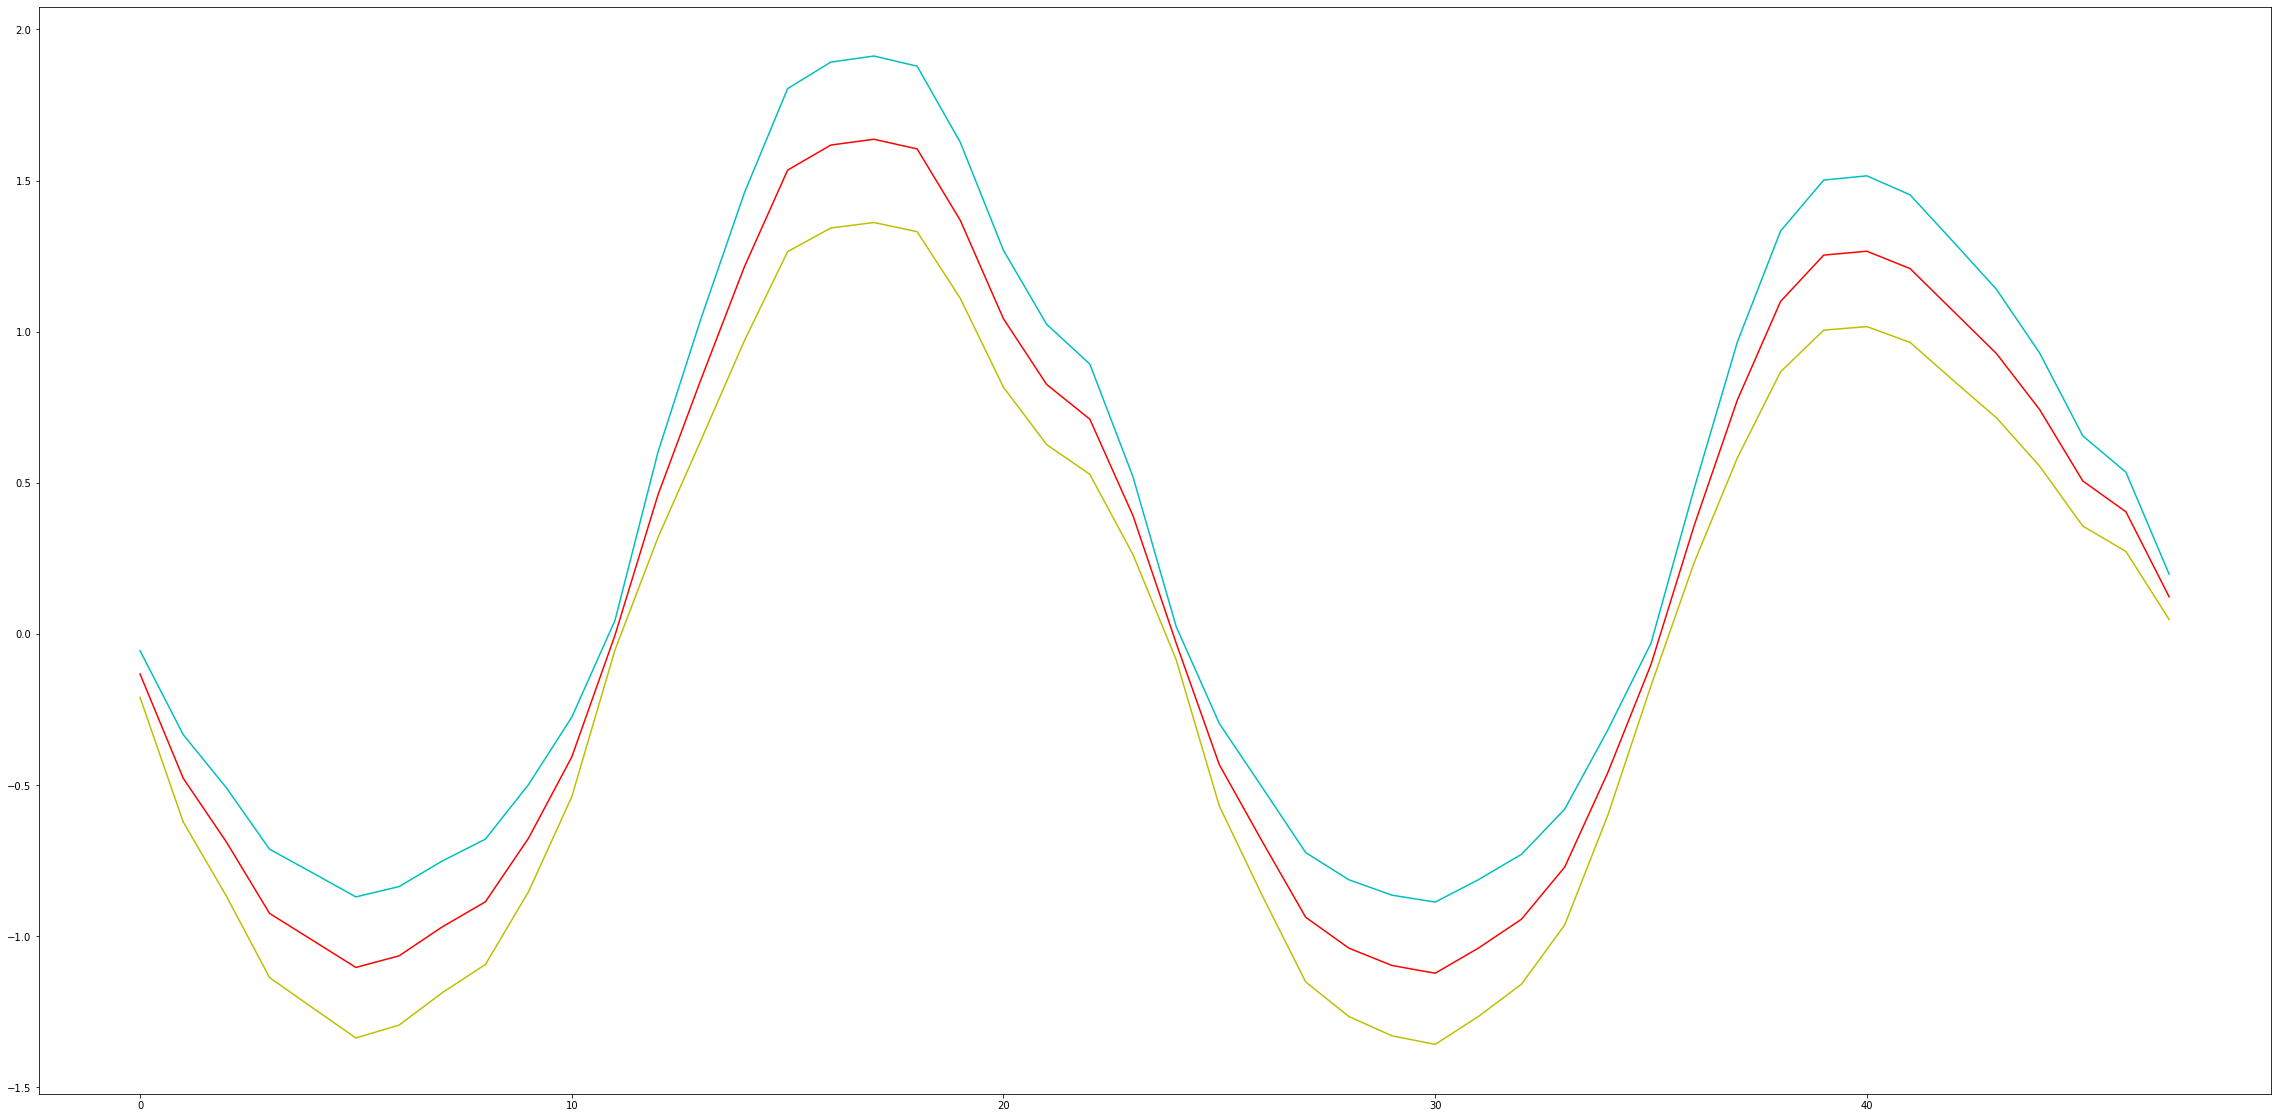

In [24]:

fig, axs = plt.subplots(1, 1, figsize=(40, 20))
    
true_series_time_axes = np.arange(0, 48)
axs.plot(true_series_time_axes, test_y[0,:48], color='r')
axs.plot(true_series_time_axes, test_y[0,:48] - test_y[0,48:], color='y')
axs.plot(true_series_time_axes, test_y[0,:48] + test_y[0,48:], color='c')

print(test_y[0,:48].min() )
print( (test_y[0,:48] - test_y[0,48:]).min())
print( (test_y[0,:48] + test_y[0,48:]).min())

# Train The Model

In [10]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')
callbacks = [callback]

model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
                output_size=OUTPUT_SIZE, learning_rate=0.02, loss = LOSS,
                dropout_ratio = 0.3, features_number = FEATURES_NUMBER, callbacks = [], pi_params=PI_PARAMS)

model.train(training_data_generator, test_data_generator, epochs=EPOCHS)

hist = model.evaluate(validation_data_generator)
print(hist)

Epoch 1/100
64/64 [==============================] - 6s 88ms/step - loss: 37198.0632 - val_loss: 1.7180
Epoch 2/100
64/64 [==============================] - 5s 74ms/step - loss: 1.6474 - val_loss: 1.4634
Epoch 3/100
64/64 [==============================] - 4s 69ms/step - loss: 1.3703 - val_loss: 1.4419
Epoch 4/100
64/64 [==============================] - 5s 72ms/step - loss: 1.3488 - val_loss: 1.3506
Epoch 5/100
64/64 [==============================] - 4s 69ms/step - loss: 1.3128 - val_loss: 1.3859
Epoch 6/100
64/64 [==============================] - 4s 68ms/step - loss: 1.1274 - val_loss: 1.3104
Epoch 7/100
64/64 [==============================] - 5s 74ms/step - loss: 1.0571 - val_loss: 1.2226
Epoch 8/100
64/64 [==============================] - 5s 78ms/step - loss: 0.9985 - val_loss: 1.1757
Epoch 9/100
64/64 [==============================] - 5s 76ms/step - loss: 0.9480 - val_loss: 1.1138
Epoch 10/100
64/64 [==============================] - 5s 75ms/step - loss: 0.9226 - val_loss: 1.

64/64 [==============================] - 4s 65ms/step - loss: 0.6496 - val_loss: 0.4458
Epoch 83/100
64/64 [==============================] - 4s 66ms/step - loss: 0.6600 - val_loss: 0.4474
Epoch 84/100
64/64 [==============================] - 4s 65ms/step - loss: 0.6681 - val_loss: 0.4718
Epoch 85/100
64/64 [==============================] - 4s 66ms/step - loss: 0.6464 - val_loss: 0.4731
Epoch 86/100
64/64 [==============================] - 4s 67ms/step - loss: 0.6465 - val_loss: 0.4531
Epoch 87/100
64/64 [==============================] - 4s 66ms/step - loss: 0.6462 - val_loss: 0.4472
Epoch 88/100
64/64 [==============================] - 4s 66ms/step - loss: 0.6417 - val_loss: 0.4786
Epoch 89/100
64/64 [==============================] - 4s 67ms/step - loss: 0.6448 - val_loss: 0.4488
Epoch 90/100
64/64 [==============================] - 4s 68ms/step - loss: 0.6472 - val_loss: 0.4418
Epoch 91/100
64/64 [==============================] - 5s 74ms/step - loss: 0.6429 - val_loss: 0.4577
Epo

# Save The Model

In [11]:
MODEL_BASE_DIR = '../models/with_kl_pi_params/3-LSTM'
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/with_kl_pi_params/3-LSTM/2


# Get Best And Worst Predictions

Best Predection Error is     9.4821
Worst Predection Error is   149.0593


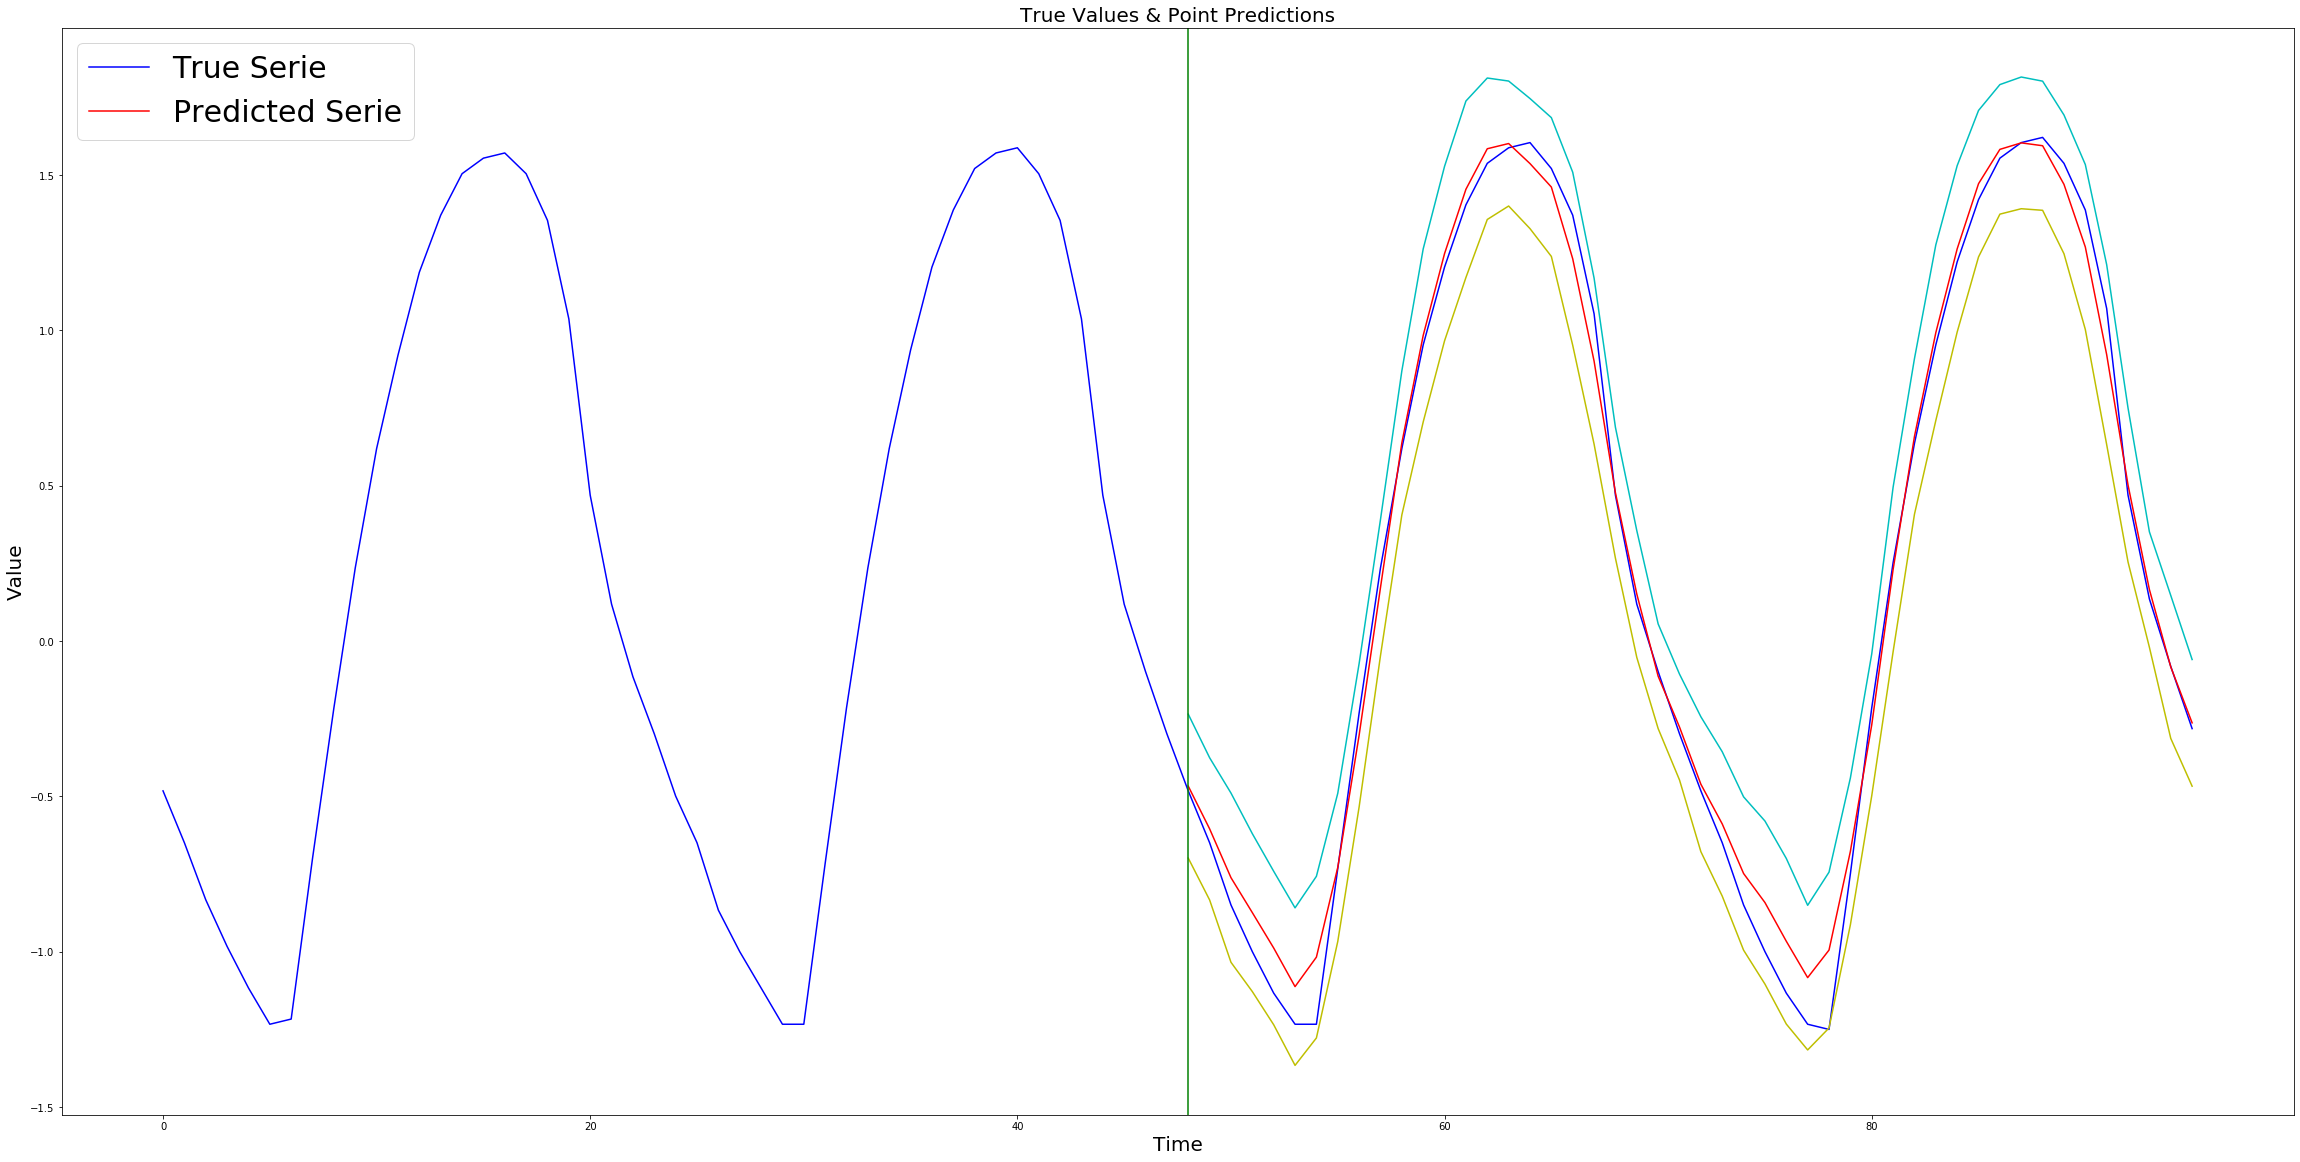

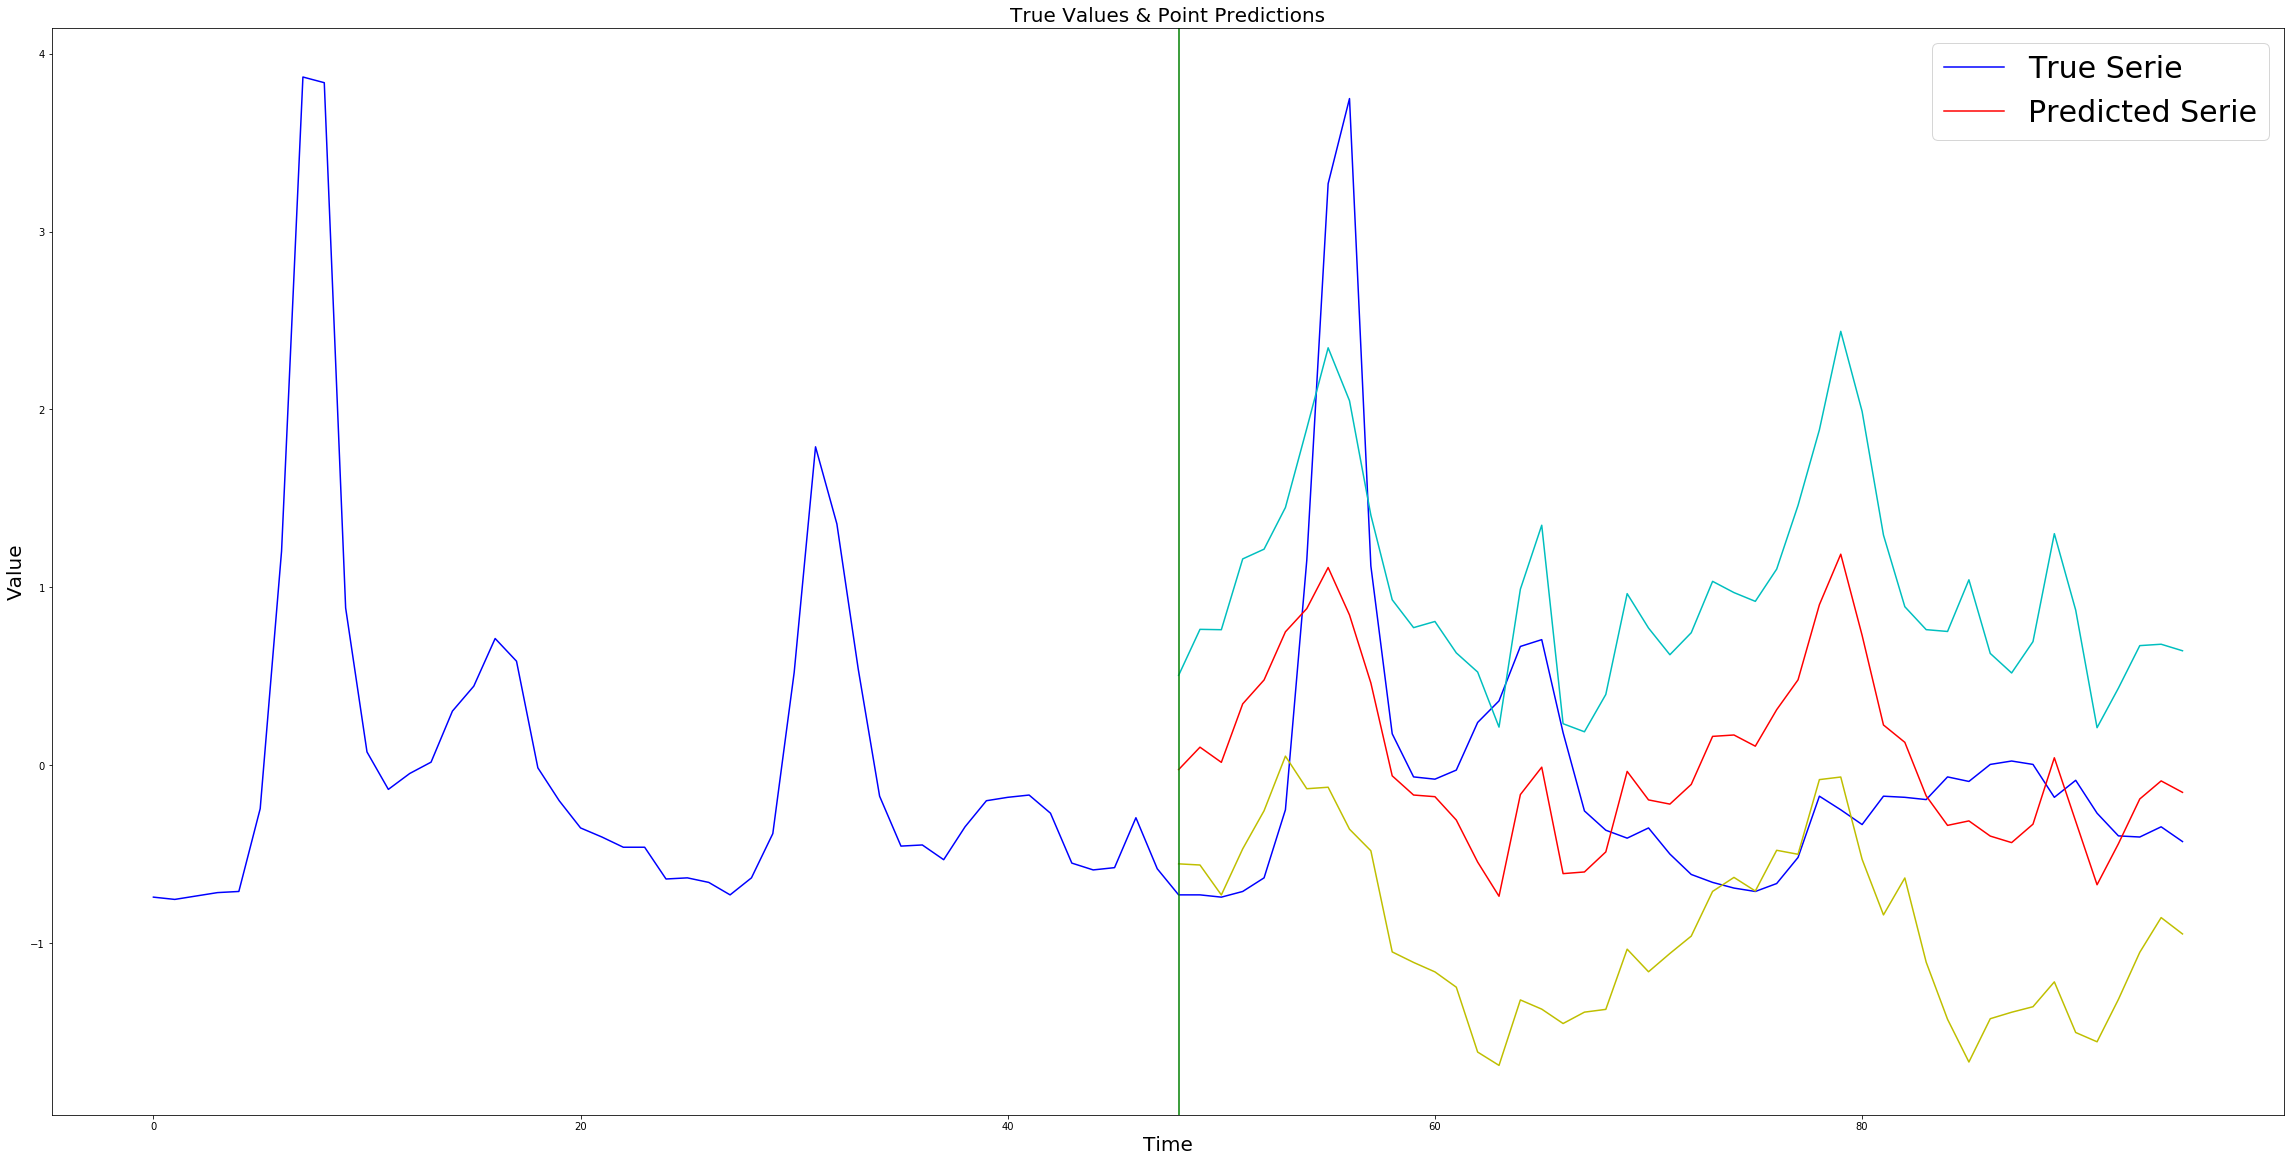

In [12]:
#model = M4Model()
#model.load('../models/with_kl/3-LSTM/7')

x, y, prediction, error =  sort_by_prediction_error(model,test_x, test_y, 
                                                    smape, features_number=FEATURES_NUMBER,
                                                    output_size = OUTPUT_SIZE)


print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[x.shape[0]-1]:10.4f}')

#plot_serie_and_prediction(x[:,:48], y[:,:48], prediction[:,:48], serie_indx=0)
#plot_serie_and_prediction(x[:,:48], y[:,:48], prediction[:,:48], serie_indx= x.shape[0]-1)
#plot_serie_and_prediction(x[:,:48], y[:,:48], prediction[:,:48] + prediction[:,-48:], serie_indx= 0)
#plot_serie_and_prediction(x[:,:48], y[:,:48], prediction[:,:48] - prediction[:,-48:], serie_indx= 0)
lower_bound = prediction[:,:48] - tf.abs(prediction[:,-48:])
upper_bound = prediction[:,:48] + tf.abs(prediction[:,-48:])
plot_serie_with_bounds(x[:,:LOOKBACK], y[:,:48], prediction[:,:48], lower_bound, upper_bound, serie_indx=0)
plot_serie_with_bounds(x[:,:LOOKBACK], y[:,:48], prediction[:,:48], lower_bound, upper_bound, serie_indx=x.shape[0]-1)

# PLot Specific Serie From A Batch

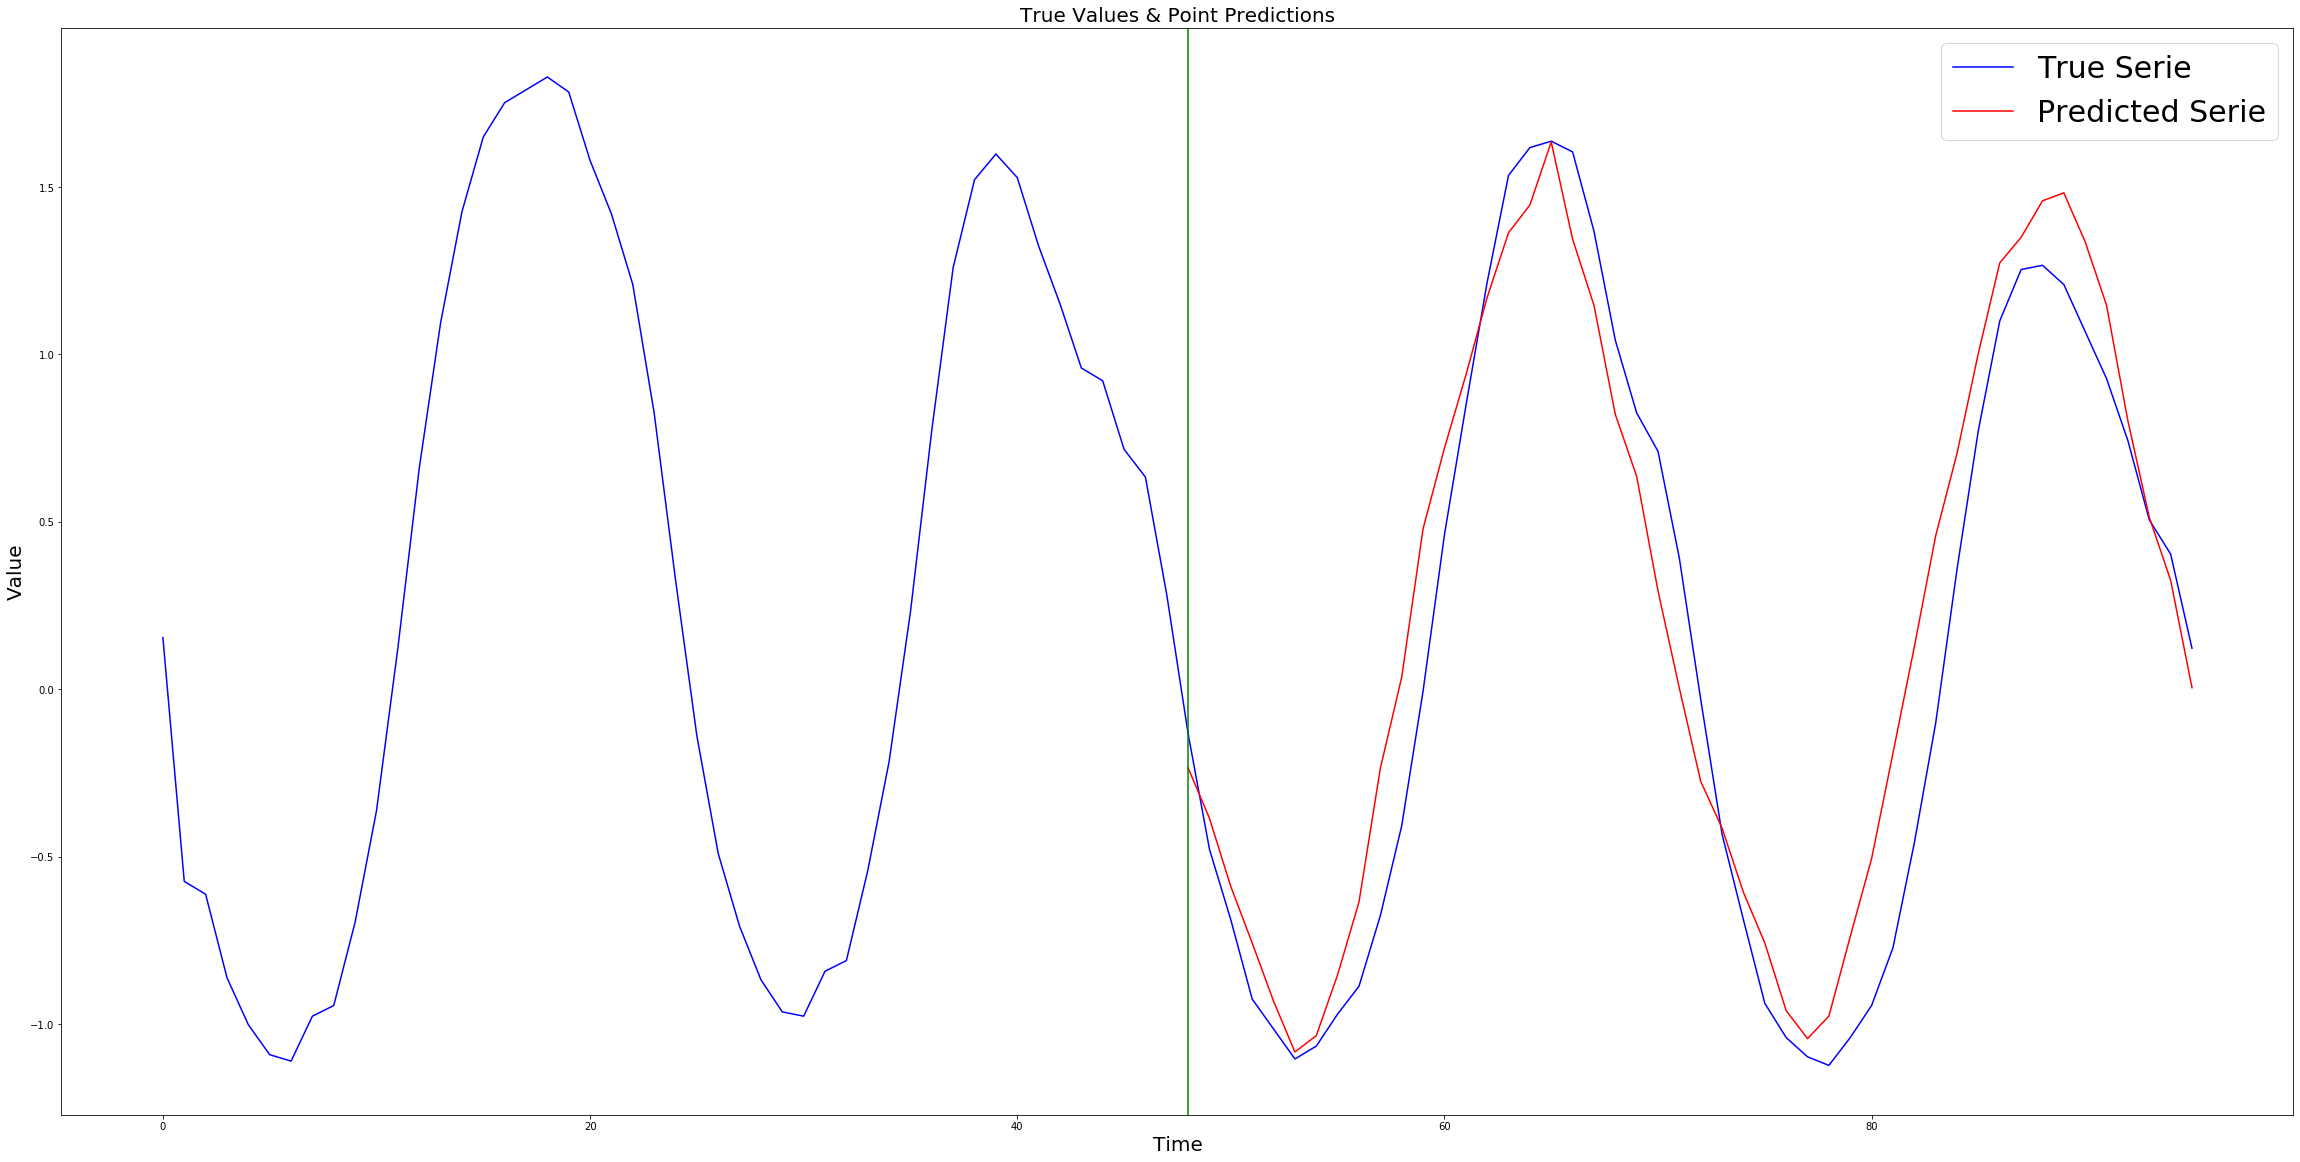

In [14]:
IDX = 0
x = test_x[:BATCH_SIZE,:]
y = test_y[:BATCH_SIZE,:]
#============ Predict Test
predictedY = model.predict(x.reshape(BATCH_SIZE, LOOKBACK, -1 ))
#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(x[:,:,0], y[:,:48], predictedY[:,:48], serie_indx=IDX)

6.90731080023688

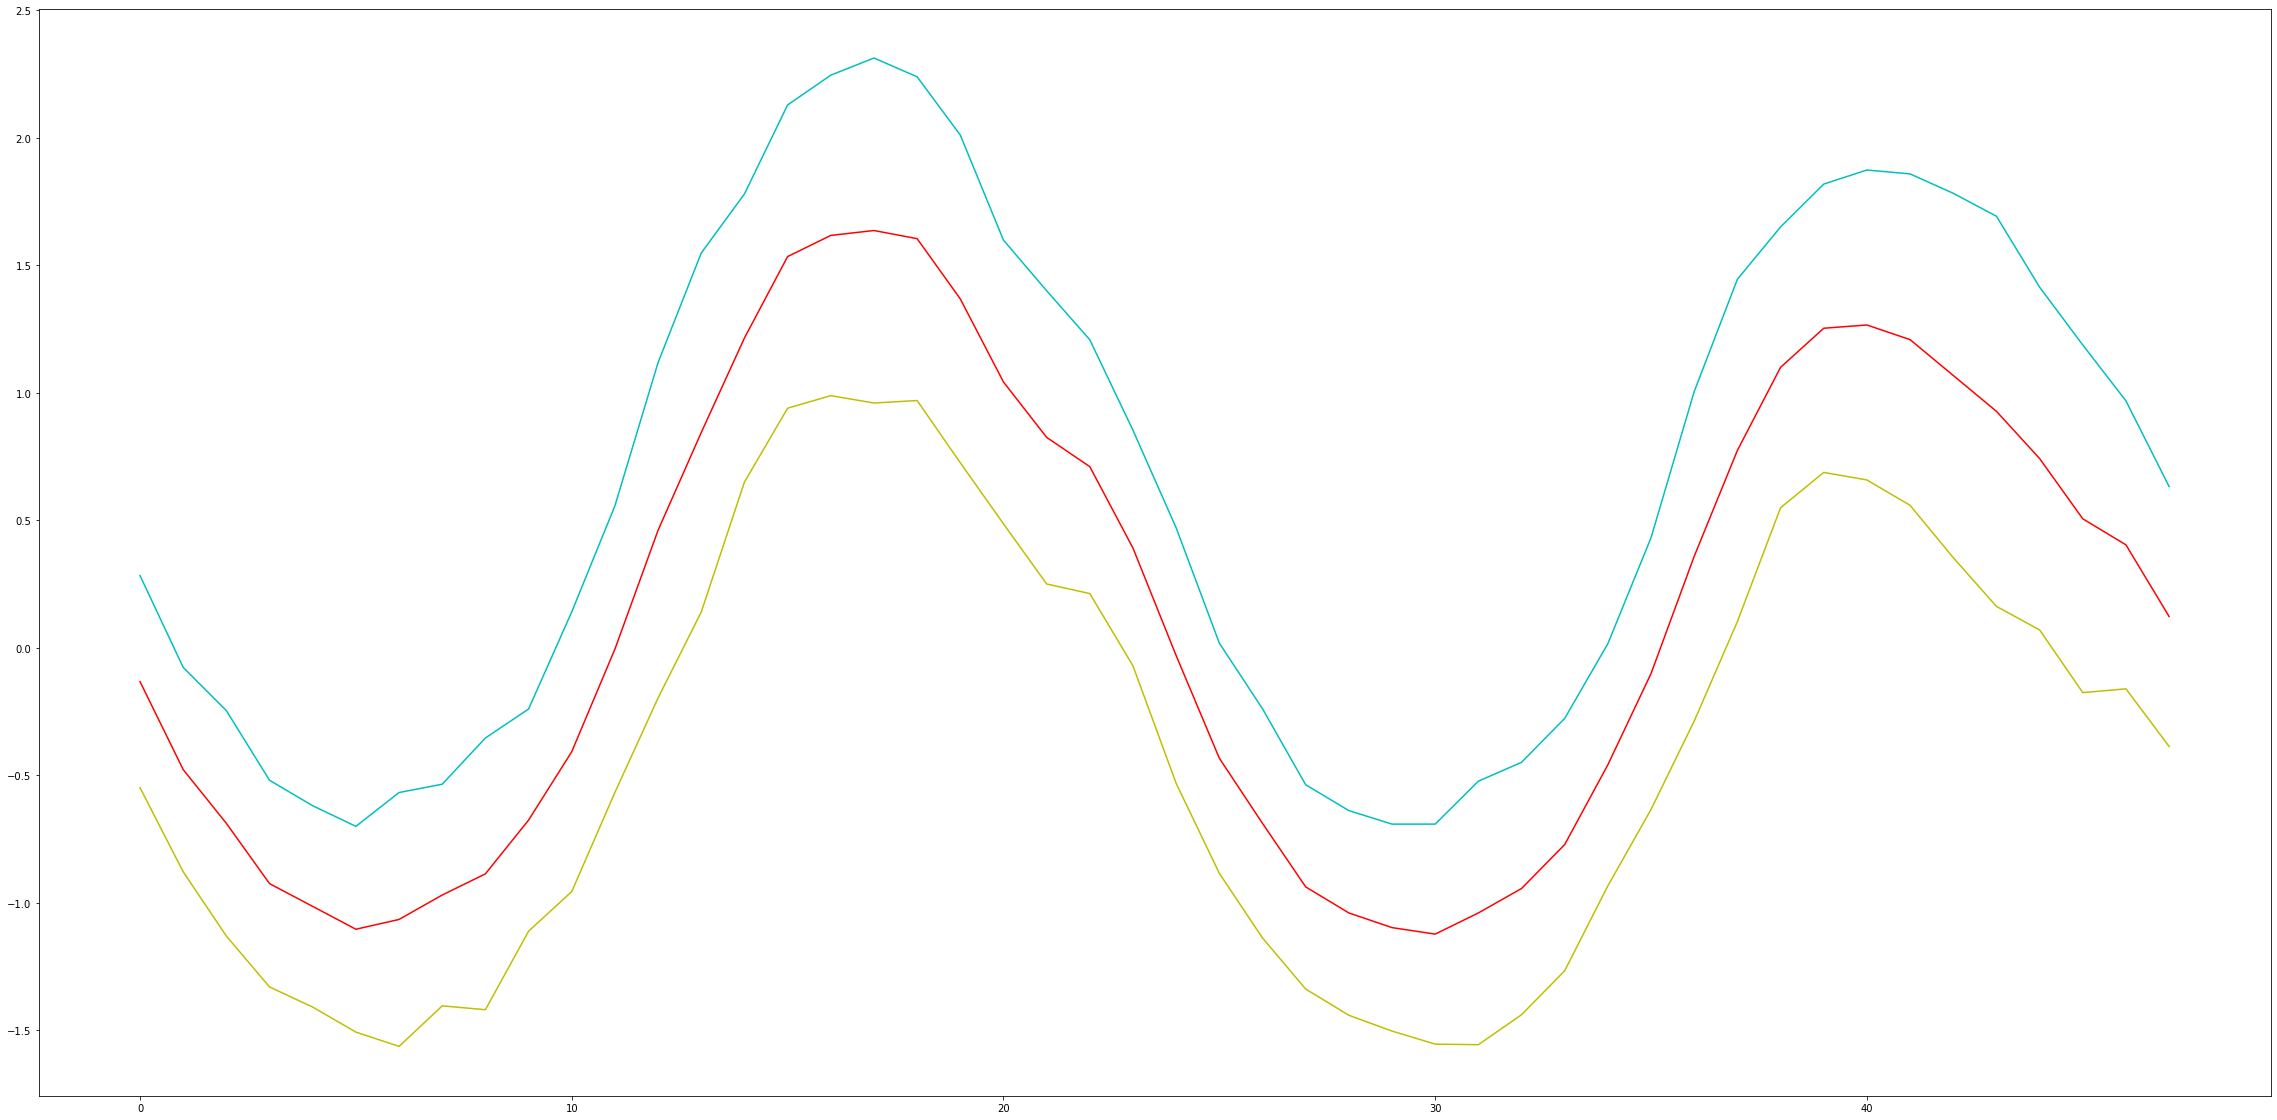

In [15]:
lower_bound = y[:100,:48] - np.abs(predictedY[:,-48:])
upper_bound = y[:100,:48] + np.abs(predictedY[:,-48:])
#plot_serie_with_bounds(test_y[:,:48], test_y[:,:48], test_y[:,:48], lower_bound, upper_bound, serie_indx=0)
data = y[0,:48]
lower = lower_bound[0,:48]
upper = upper_bound[0,:48]
fig, axs = plt.subplots(1, 1, figsize=(40, 20))

time_axs = np.arange(0, 48)
axs.plot(time_axs, data, color='r')
axs.plot(time_axs, lower, color='y')
axs.plot(time_axs, upper, color='c')
validate_x.max()

# Evaluate A Model Against An Error Function

In [17]:
MODEL_NUMBER = 2
MODEL_BASE_DIR = '../models/with_kl_pi_params/3-LSTM'
hyperparameters, training_error, test_error, validation_error = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', 
                                                                       '../Dataset/Train/Hourly-train.csv', 
                                                                       '../Dataset/Test/Hourly-test.csv', mase, pi_params=PI_PARAMS)
print(f'Hyperparameters : {hyperparameters}')
print(f'Training Error For Model ({MODEL_NUMBER}) : {training_error}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {test_error}')
print(f'Validation Error For Model ({MODEL_NUMBER}) : {validation_error}')

Loaded model from disk
Hyperparameters : {'epochs': 100, 'batch_size': 100, 'hidden_layer_size': 20, 'lookback': 48, 'loss': 'kl_divergance', 'dropout_ratio': 0.3, 'features_number': 2, 'output_size': 96, 'pi_params': {'max_coff': 0.5, 'min_coff': 0.09, 'step': 0.1}}
Training Error For Model (2) : 1.172
Test Error For Model (2) : 1.256
Validation Error For Model (2) : 1.204
